In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

import yfinance as yf
from yahooquery import Ticker
import datetime as dt


In [2]:
class Option:
    
    def __init__(self, S, K, T, v, r, d):
        self.S = S # Stock Price
        self.K = K # Strike Price
        self.T = T # Time to Maturity (in years)
        self.v = v # Volatility (annualized)
        self.r = r # risk free rate
        self.d = d # dividend rate

    def black_scholes(self, Call=None, Put=None, 
                      delta=None, gamma=None, theta=None, vega=None, rho=None):
        '''
        This works for European Options only
        '''
        d1 = (np.log(self.S / self.K) + ((self.r-self.d)+((self.v**2)/2))*self.T) / (self.v*(self.T**0.5))
        d2 = d1 - self.v*(self.T**0.5)
        
        if gamma == True:
            g = norm.pdf(d1) / (self.S*self.v*(self.T**0.5))
            return(g)
        if vega == True:
            return(self.S*(self.T**0.5)*norm.pdf(d1)*np.exp(-self.d*self.T))

        if Call == True:
            if delta == True:
                return(norm.cdf(d1))
            if theta == True:
                theta_wrt_T = ((-self.S*np.exp(-self.d*self.T)*self.v*norm.pdf(d1))/(2*(self.T**.5))) - (self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(d2))
                return( theta_wrt_T / 252 ) # T is in years, we return theta wrt days
            if rho == True:
                return(self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(d2))

            p = (norm.cdf(d1)*self.S*np.exp(-self.d*self.T) - norm.cdf(d2)*self.K*np.exp(-self.r*self.T))
            return(p)
            
        if Put == True:
            if delta == True:
                return(-norm.cdf(-d1))
            if theta == True:
                theta_wrt_T = ((-self.S*np.exp(-self.d*self.T)*self.v*norm.pdf(d1))/(2*(self.T**.5))) + (self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(-d2))
                return( theta_wrt_T / 252 ) # T is in years, we return theta wrt days
            if rho == True:
                return(-self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(-d2))

            p = (norm.cdf(-d2)*self.K*np.exp(-self.r*self.T) - norm.cdf(-d1)*self.S*np.exp(-self.d*self.T))
            return(p)
        
    def monte_carlo(self, n_sims, Call=None, Put=None, European=None, American=None):
        '''
        This works for European Options and can make it work for American Options
        '''
        payoffs = []
        
        for i in range(n_sims):
            WW = (self.T**0.5) * np.random.normal(0,1,1)
            
            for W in [WW, -WW]: # Antithetic Variates (Variance Reduction Technique)
                S = self.S * np.exp((self.v*W) + (self.r-self.d-((self.v**2)/2))*self.T)

                if Call == True:
                    recieve = S
                    pay = self.K
                if Put == True:
                    recieve = self.K
                    pay = S

                payoffs.append(max(recieve-pay,0))
                
        p = float(np.exp(-self.r*self.T) * np.mean(payoffs))
        return(p)

    def binomial(self, n_steps, Call=None, Put=None, American=None):
        if self.T == 0:
            if Call == True:
                return(max(self.S-self.K,0))
            if Put == True:
                return(max(self.K-self.S,0))
        interest = np.exp((self.r-self.d) * (self.T/n_steps)) # i-rate at each step
        discount = np.exp(-self.r * (self.T/n_steps)) # discount-rate at each step --> this is 1/(r*dt)

        u = np.exp(self.v * np.sqrt(self.T/n_steps)) # up movement
        uu = u**2
        d = 1.0/u

        p_up = (interest-d)/(u-d)
        p_down = 1-p_up

        # fill in the endnodes of the tree (when the option expires)
        prices = [] # underlying stock price at option maturity
        prices.append(self.S*(d**n_steps)) # wrost case scenario for underlying stock at option maturity
        for i in range(n_steps):
            prices.append(uu*prices[i]) # all other endnodes

        option_values = [] # option payoffs at maturity
        for i in range(n_steps+1):
            if Call == True:
                option_values.append(max(0, prices[i]-self.K))
            if Put == True:
                option_values.append(max(0, self.K-prices[i]))

        # loop through the tree to find option price today (at time 0)
        for step in range(n_steps-1,-1,-1): # time index going back in time through the tree horizontally
            for i in range(step+1): # price index going through all of the nodes of the tree vertically at each point in time
                option_values[i] = (p_up*option_values[i+1]+p_down*option_values[i])*discount;

                if American == True:
                    prices[i] *= u ## CAN ALSO DO "prices[i] = d*prices[i+1];" here !
                    if Call == True:
                        option_values[i] = max(option_values[i],prices[i]-self.K) # check for exercise
                    if Put == True:
                        option_values[i] = max(option_values[i],self.K-prices[i]) # check for exercise
        return(option_values[0])

    def greeks(self, n_steps=None, n_sims=None, Call=None, Put=None, American=None,
               delta=None, gamma=None, theta=None, vega=None, rho=None):
        '''
        n_sims == None & n_steps == None --> estimate greek using Black Scholes option price
        n_sims == a number --> estimate greek using Monte Carlo simulation of the option price (with n_sims)
        n_steps == a number --> estimate greek using Binomial model option price (with n_steps)

        '''
        
        epsilon = 0.01 # compute option sensitivity to a 0.1% change in the option's parameters
        
        if delta == True:
            self.S *= (1+epsilon) # increase stock price by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.S *= (1-epsilon)/(1+epsilon) # decrease stock price by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.S /= (1-epsilon) # bring stock price back to what it was previously
            
            d = (forward - backward) / (2*epsilon*self.S)
            return(d)

        if gamma == True:
            self.S *= (1+epsilon) # increase stock price by epsilon %
            forward = self.greeks(n_sims=n_sims, n_steps=n_steps, Call=Call, Put=Put, delta=True, American=American)

            self.S *= (1-epsilon)/(1+epsilon) # decrease stock price by epsilon %
            backward = self.greeks(n_sims=n_sims, n_steps=n_steps, Call=Call, Put=Put, delta=True, American=American)

            self.S /= (1-epsilon) # bring stock price back to what it was previously
            
            g = (forward - backward) / (2*epsilon*self.S)
            return(g)

        if theta == True:            
            self.T *= (1-epsilon) # decrease T (pull time forward) by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.T *= (1+epsilon)/(1-epsilon) # increase T (pull time backward) by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.T /= (1+epsilon) # bring T back to what it was previously
            theta_wrt_T = (forward - backward) / (2*epsilon*self.T)
            return( theta_wrt_T / 252 ) # T is in years, we return theta wrt days

        if vega == True:            
            self.v *= (1+epsilon) # increase vol by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.v *= (1-epsilon)/(1+epsilon) # decrease vol by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.v /= (1-epsilon) # bring vol back to what it was previously
            
            v = (forward - backward) / (2*epsilon*self.v)
            return(v)
        
        if rho == True:            
            self.r *= (1+epsilon) # increase r by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.r *= (1-epsilon)/(1+epsilon) # decrease r by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.r /= (1-epsilon) # bring r back to what it was previously
            
            rho = (forward - backward) / (2*epsilon*self.r)
            return(rho)



In [3]:
# Provide option specs:
option1 = Option(S=90, K=100, T=1, v=0.25, r=0.04, d=0.01)


# Option Price


In [4]:
print(option1.black_scholes(Call=True))
print(option1.monte_carlo(Call=True, n_sims=10000))

print(option1.binomial(Call=True, n_steps=1000)) #European Option by default
print(option1.binomial(Call=True, n_steps=1000, American=True)) #American Option

6.136398139308966
6.219471251563076
6.137879474392158
6.137879474398411


In [5]:
print(option1.black_scholes(Put=True))
print(option1.monte_carlo(Put=True, n_sims=10000))

print(option1.binomial(Put=True, n_steps=1000)) #European Option by default
print(option1.binomial(Put=True, n_steps=1000, American=True)) #American Option

13.11085701711616
13.135470026745732
13.112338352201421
13.72886297417097


# Option Delta

In [6]:
print(option1.black_scholes(Call=True, delta=True))

print(option1.greeks(Call=True, delta=True))
print(option1.greeks(n_sims=200000, Call=True, delta=True))
print(option1.greeks(n_steps=2000, Call=True, delta=True))

print(option1.greeks(n_steps=2000, Call=True, delta=True, American=True))

0.42997333089093615
0.42568740479838885
0.3968524653545339
0.42587007371146884
0.4258700737134593


In [7]:
print(option1.black_scholes(Put=True, delta=True))

print(option1.greeks(Put=True, delta=True))
print(option1.greeks(n_sims=200000, Put=True, delta=True))
print(option1.greeks(n_steps=2000, Put=True, delta=True))

print(option1.greeks(n_steps=2000, Put=True, delta=True, American=True))

-0.5700266691090629
-0.5643624289507755
-0.5500974394646644
-0.5641797600374572
-0.6061718838759995


# Option Gamma

In [8]:
print(option1.black_scholes(Call=True, gamma=True))

print(option1.greeks(Call=True, gamma=True))
print(option1.greeks(n_sims=200000, Call=True, gamma=True))
print(option1.greeks(n_steps=2000, Call=True, gamma=True))

print(option1.greeks(n_steps=2000, Call=True, gamma=True, American=True))

0.017456909599013845
0.017274048128347663
-0.010060688760914096
0.017035093628836685
0.017035093629390964


In [9]:
print(option1.black_scholes(Put=True, gamma=True))

print(option1.greeks(Put=True, gamma=True))
print(option1.greeks(n_sims=200000, Put=True, gamma=True))
print(option1.greeks(n_steps=2000, Put=True, gamma=True))

print(option1.greeks(n_steps=2000, Put=True, gamma=True, American=True))

0.01745690959901384
0.017274048128346237
0.014403431832466541
0.01703509362902931
0.019866140356057837


# Option Theta

In [10]:
print(option1.black_scholes(Call=True, theta=True))

print(option1.greeks(Call=True, theta=True))
print(option1.greeks(n_sims=400000, Call=True, theta=True))
print(option1.greeks(n_steps=2000, Call=True, theta=True))


print(option1.greeks(n_steps=2000, Call=True, theta=True, American=True))

-0.02246769368173133
-0.020947486083433907
-0.02501811435688809
-0.020924438978034112
-0.0209244389785998


In [11]:
print(option1.black_scholes(Put=True, theta=True))

print(option1.greeks(Put=True, theta=True))
print(option1.greeks(n_sims=400000, Put=True, theta=True))
print(option1.greeks(n_steps=2000, Put=True, theta=True))

print(option1.greeks(n_steps=2000, Put=True, theta=True, American=True))

-0.007217067663440486
-0.009232751927742228
-0.008374749948271618
-0.009209704819054412
-0.011437233781286426


# Option Vega

In [12]:
print(option1.black_scholes(Call=True, vega=True))

print(option1.greeks(Call=True, vega=True))
print(option1.greeks(n_sims=400000, Call=True, vega=True))
print(option1.greeks(n_steps=2000, Call=True, vega=True))

print(option1.greeks(n_steps=2000, Call=True, vega=True, American=True))

34.9985011537129
34.998336316624545
36.36650161656814
34.95249340029183
34.952493401358886


In [13]:
print(option1.black_scholes(Put=True, vega=True))

print(option1.greeks(Put=True, vega=True))
print(option1.greeks(n_sims=400000, Put=True, vega=True))
print(option1.greeks(n_steps=2000, Put=True, vega=True))

print(option1.greeks(n_steps=2000, Put=True, vega=True, American=True))

34.9985011537129
34.998336316623124
35.13085542413634
34.952493401071294
33.33975822070947


## Consider the following information on the stock of a company and options on it: 𝑆0 = 49, K = 50, 𝑟 = 0.03, 𝜎 = 0.2, 𝑇 = 0.3846 (20 weeks), 𝜇 = 0.14. Find:
#### 1- Delta of the call option as a function of 𝑆0, for 𝑆0 ranging from 20 to 80, in increments of 2.
#### 2- Delta of the call option, as a function of T (time to expiration), from 0 to 0.3846 in increments of 0.01
#### 3- Theta of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.
#### 4- Gamma of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.
#### 5- Vega of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.
#### 6- Rho of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.

In [14]:
def plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(20,13))

    ax1.plot(x,deltas)
    ax1.set_title('Delta ~ S', size=17)
    ax1.set_xlabel('S$_t$', size=15)
    ax1.tick_params(axis='both', labelsize=12)

    ax2.plot(x2,deltas_wrt_time)
    ax2.set_title('Delta ~ t', size=17)
    ax2.set_xlabel('Time to Maturity (yr)', size=13)
    ax2.tick_params(axis='both', labelsize=12)

    ax3.plot(x,thetas)
    ax3.set_title('Theta', size=17)
    ax3.set_xlabel('S$_t$', size=15)
    ax3.tick_params(axis='both', labelsize=12)

    ax4.plot(x,gammas)
    ax4.set_title('Gamma', size=17)
    ax4.set_xlabel('S$_t$', size=15)
    ax4.tick_params(axis='both', labelsize=12)

    ax5.plot(x,vegas)
    ax5.set_title('Vega', size=17)
    ax5.set_xlabel('S$_t$', size=15)
    ax5.tick_params(axis='both', labelsize=12)

    ax6.plot(x,rhos)
    ax6.set_title('Rho', size=17)
    ax6.set_xlabel('S$_t$', size=15)
    ax6.tick_params(axis='both', labelsize=12)

    plt.show()

## First, estimate the greeks by the BS closed form solutions

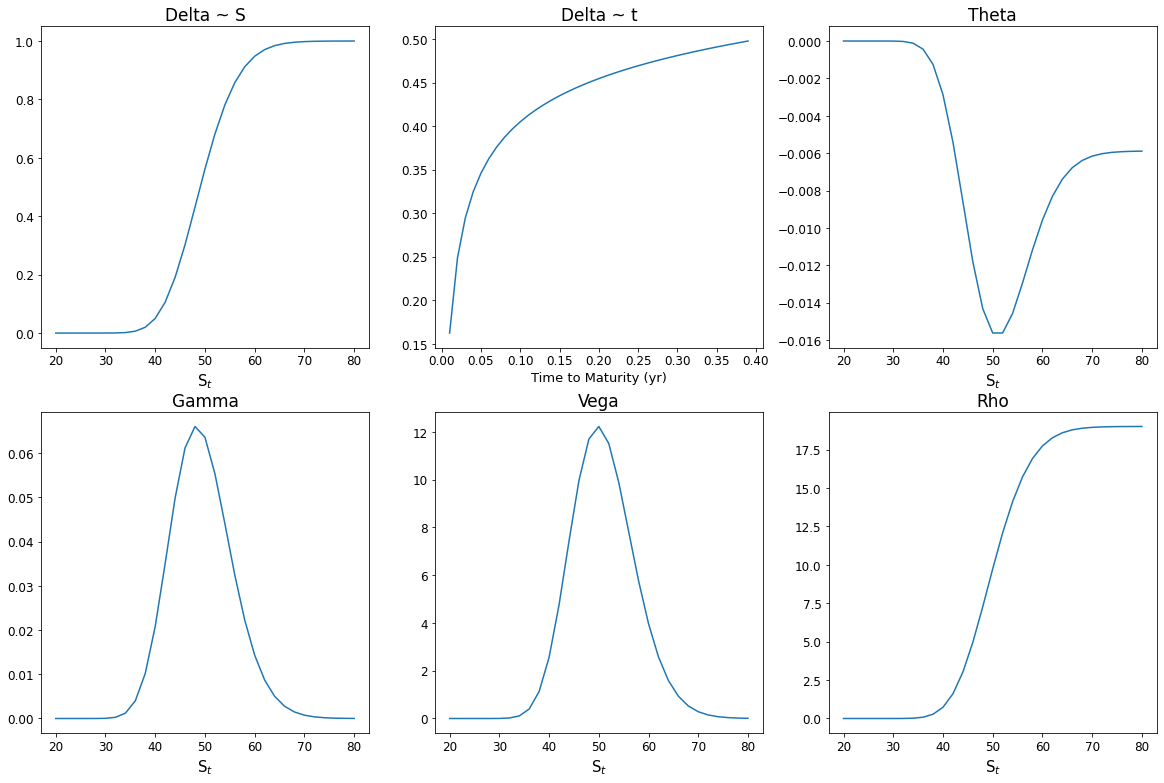

In [15]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.black_scholes(Call=True, delta=True))
    gammas.append(option2.black_scholes(Call=True, gamma=True))
    thetas.append(option2.black_scholes(Call=True, theta=True))
    vegas.append(option2.black_scholes(Call=True, vega=True))
    rhos.append(option2.black_scholes(Call=True, rho=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.black_scholes(Call=True, delta=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Next, estimate the greeks by using the BS model sensitivity

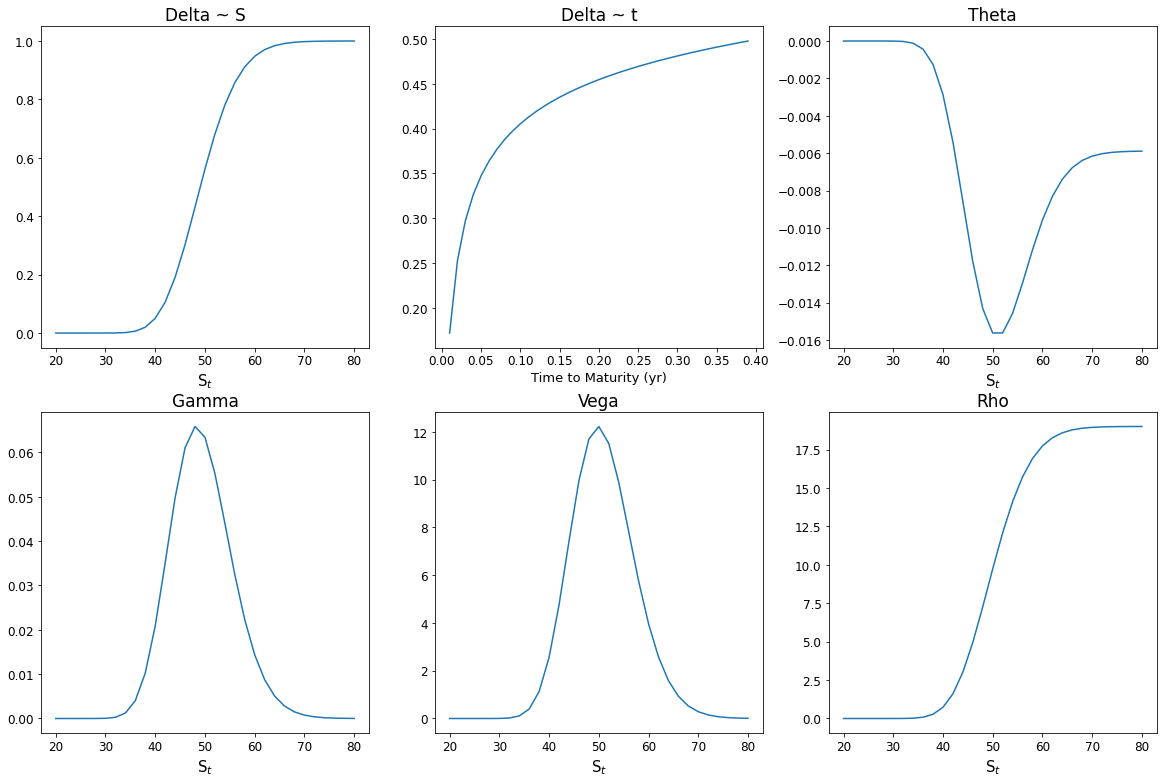

In [16]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True))
    gammas.append(option2.greeks(Call=True, gamma=True))
    thetas.append(option2.greeks(Call=True, theta=True))
    vegas.append(option2.greeks(Call=True, vega=True))
    rhos.append(option2.greeks(Call=True, rho=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Next, estimate the greeks by using the binomial method with n_steps = 500

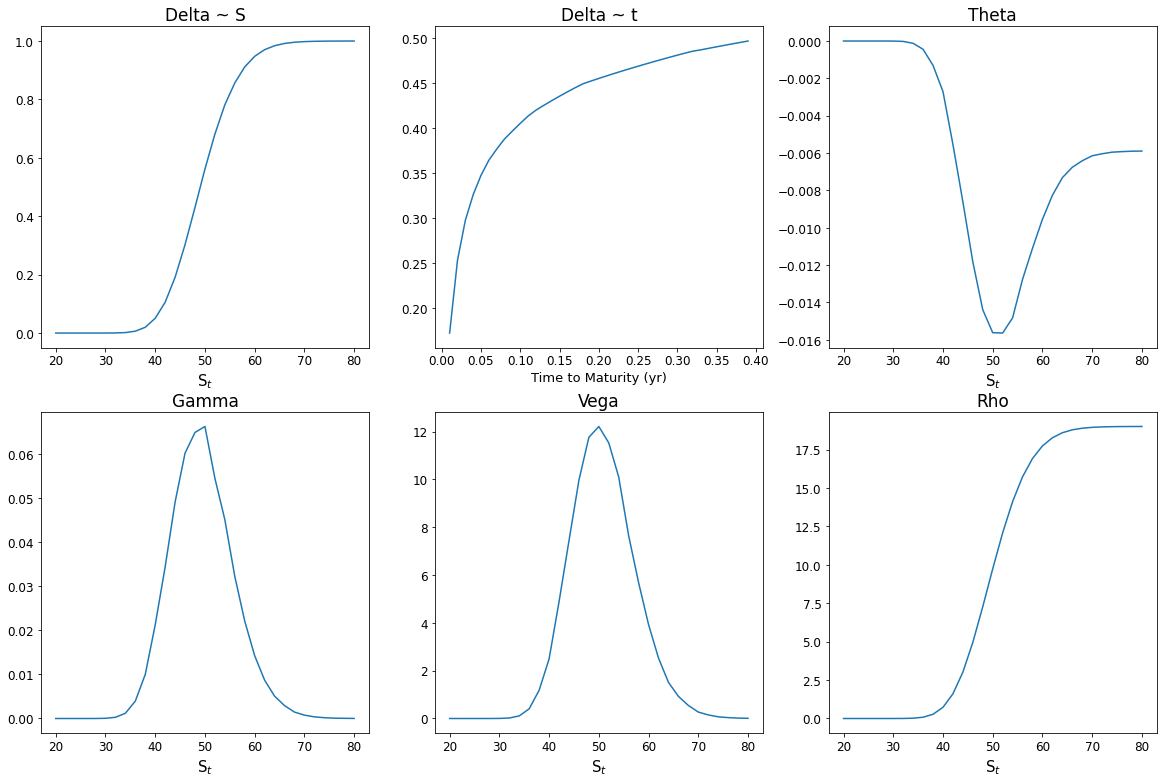

In [17]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True, n_steps=500))
    gammas.append(option2.greeks(Call=True, gamma=True, n_steps=500))
    thetas.append(option2.greeks(Call=True, theta=True, n_steps=500))
    vegas.append(option2.greeks(Call=True, vega=True, n_steps=500))
    rhos.append(option2.greeks(Call=True, rho=True, n_steps=500))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True, n_steps=500))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Try again but this time use n_sims = 200,000 monte-carlo simulations
##### Will take more time to run compared with estimating the greeks by using the BS model or binomial model sensitivities



20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,

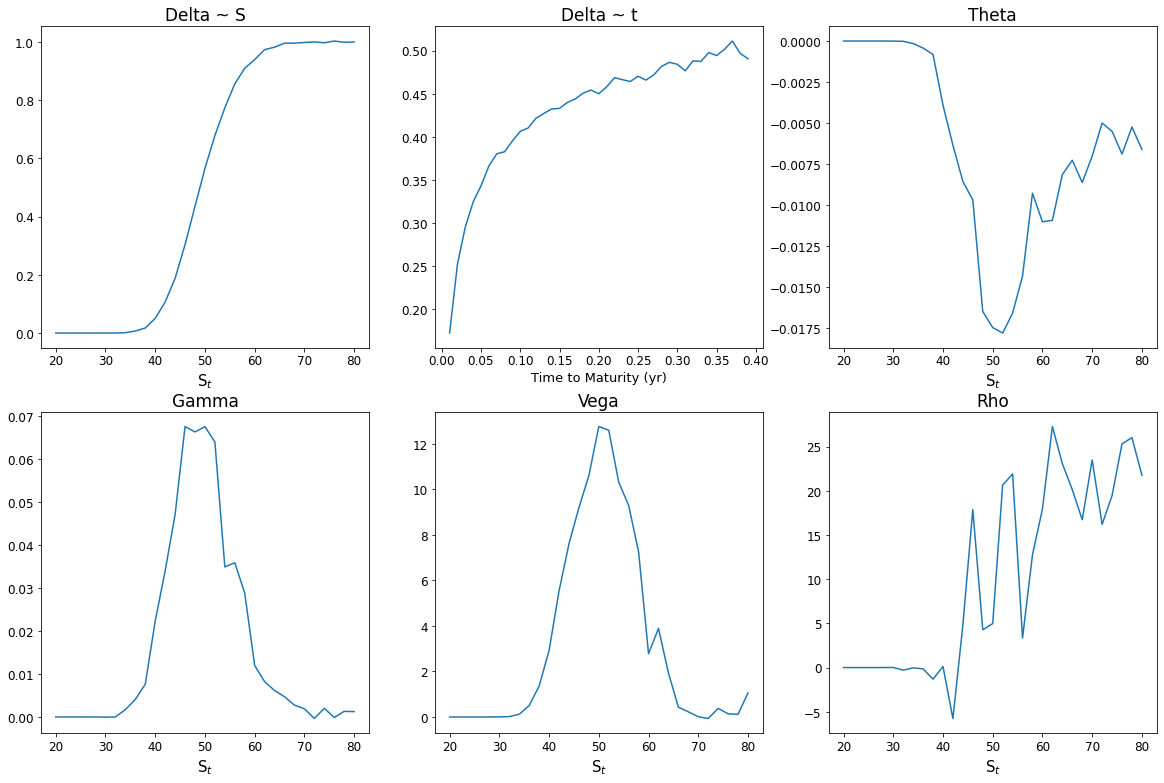

In [18]:
# Try again but this time use n_sims = 100,000 monte-carlo simulations
# this will take a lot more time to run compared with estimating the greeks by using the BS model sensitivity

option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(n_sims=200000, Call=True, delta=True))
    gammas.append(option2.greeks(n_sims=200000, Call=True, gamma=True))
    thetas.append(option2.greeks(n_sims=200000, Call=True, theta=True))
    vegas.append(option2.greeks(n_sims=200000, Call=True, vega=True))
    rhos.append(option2.greeks(n_sims=200000, Call=True, rho=True))
    print(round(option2.S), end=",") # to keep track of loop progress
    
option2.S = 49 # set stock price back to 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(n_sims=200000, Call=True, delta=True))
    print(round(option2.T,2), end=",") # to keep track of loop progress

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Try again but this time use n_steps = 500 binomial tree for American Options

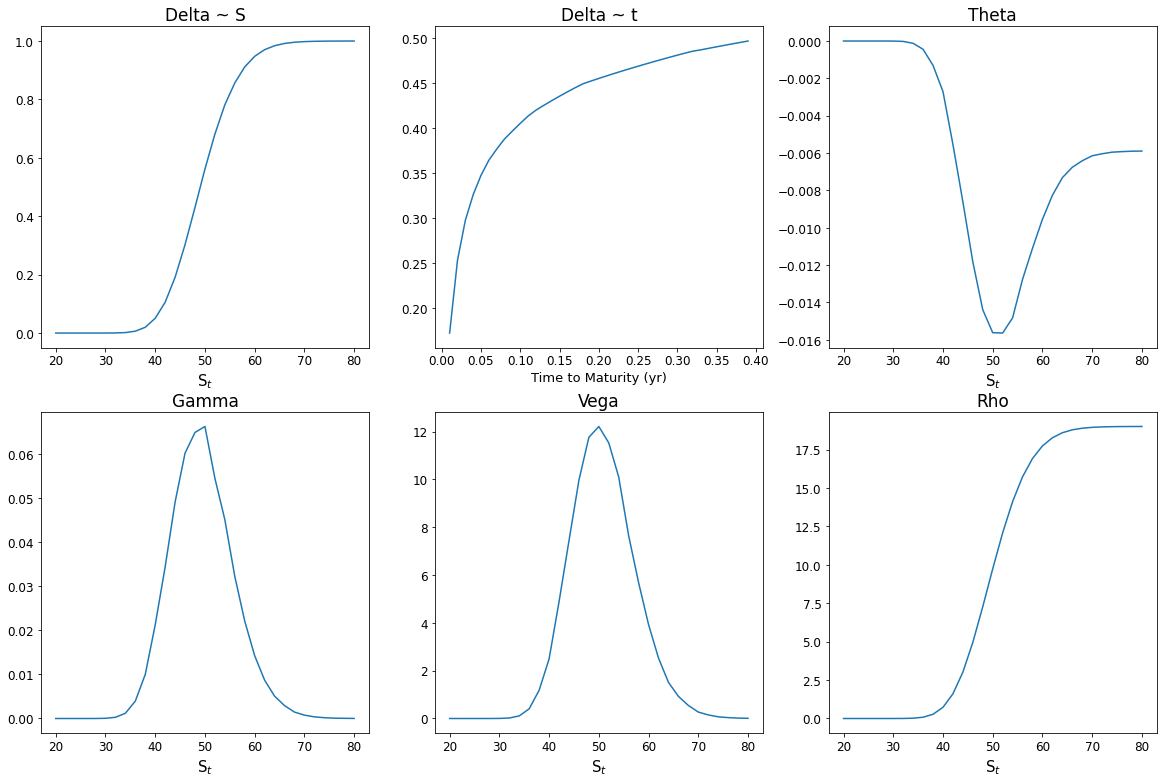

In [19]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))
    gammas.append(option2.greeks(Call=True, gamma=True, n_steps=500, American=True))
    thetas.append(option2.greeks(Call=True, theta=True, n_steps=500, American=True))
    vegas.append(option2.greeks(Call=True, vega=True, n_steps=500, American=True))
    rhos.append(option2.greeks(Call=True, rho=True, n_steps=500, American=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Try again but this time use the binomial for American Options on dividend paying stock

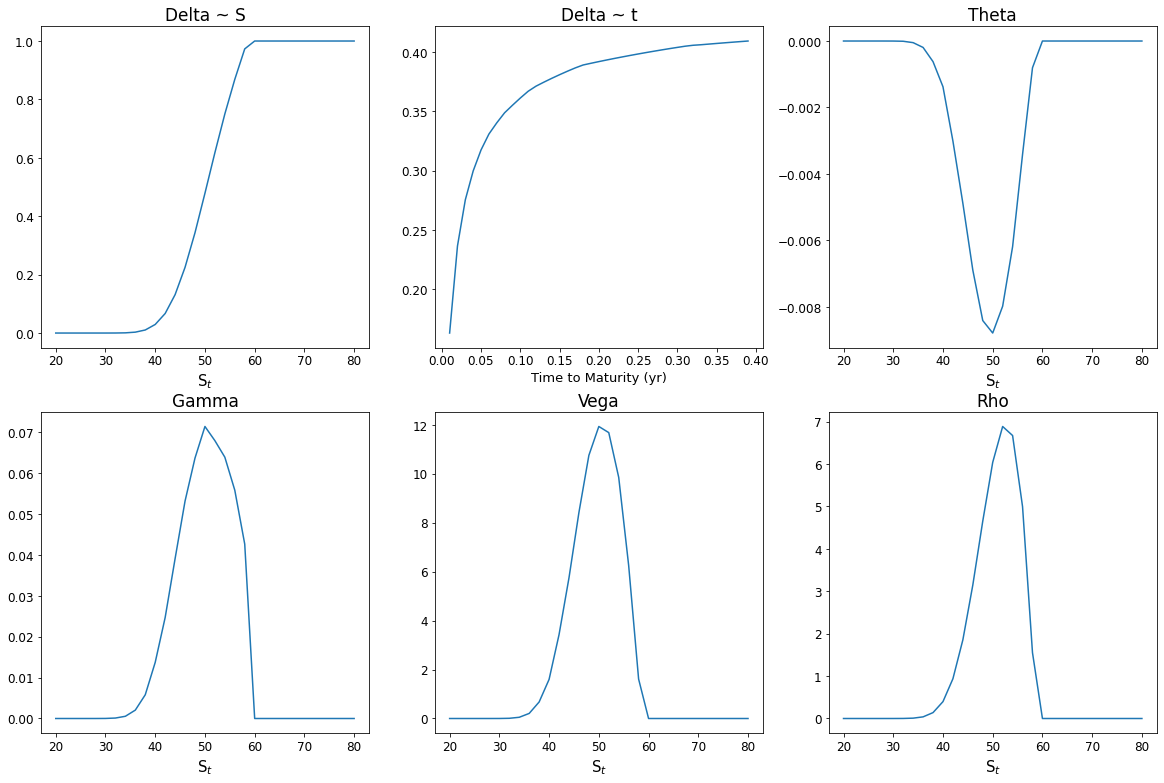

In [20]:
# American option on dividend paying:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0.08) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))
    gammas.append(option2.greeks(Call=True, gamma=True, n_steps=500, American=True))
    thetas.append(option2.greeks(Call=True, theta=True, n_steps=500, American=True))
    vegas.append(option2.greeks(Call=True, vega=True, n_steps=500, American=True))
    rhos.append(option2.greeks(Call=True, rho=True, n_steps=500, American=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

### Model American Call price on AMZN with S=range(60,140), K=100, T=range(0,2), v=?, r=0.04,d=0)


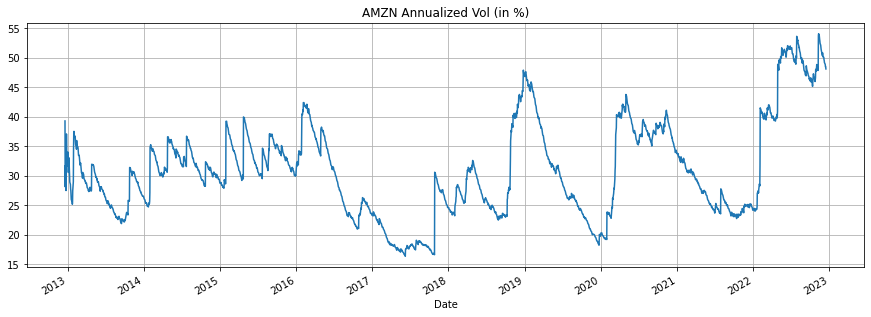

In [21]:
# Find AMZN 180d EWMA vol with halflife of 45d
#import yfinance as yf

halflife = 45
tickers = ['AMZN']
for ticker in tickers:
    ticker_yahoo = yf.Ticker(ticker)
    ret = ticker_yahoo.history(period='10y').Close.pct_change(1).dropna()
ewma_vol = ret.ewm(halflife=halflife).std()*(252**0.5)

# plot
(100*ewma_vol).dropna().plot(title='AMZN Annualized Vol (in %)', figsize=(15,5), grid=True);

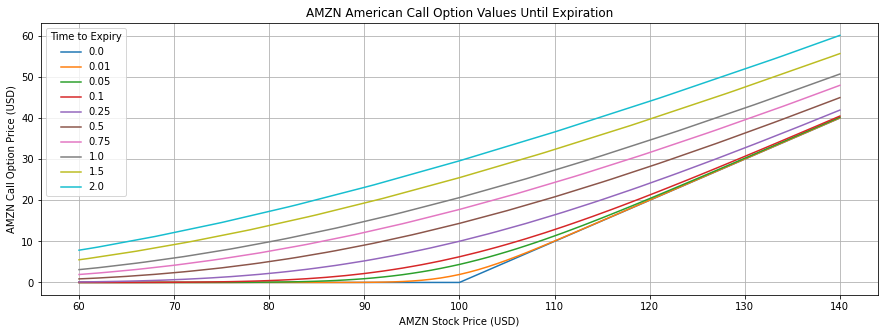

In [22]:
# American Call on AMZN:
range_T = [0,0.01,0.05,0.1,0.25,0.5,0.75,1,1.5,2]  #[i/10 for i in range(6)]
range_S = range(60,141)
prices = pd.DataFrame(index=range_S, columns=range_T)
for T in range_T:
    #print('Time: ', T) # to keep track of progress
    for S in range_S:
        amzn = Option(S=S, K=100, T=T, v=ewma_vol[-1], r=0.04, d=0) #initialize object
        prices.loc[S,T] = amzn.binomial(Call=True, n_steps=200, American=True) #American Option

# plot
prices.plot(title = 'AMZN American Call Option Values Until Expiration', figsize=(15,5), grid=True)
plt.ylabel('AMZN Call Option Price (USD)')
plt.xlabel('AMZN Stock Price (USD)')
plt.legend(title='Time to Expiry')
plt.show()

### American Put price on AMZN with S=range(60,140), K=100, T=range(0,2), v=?, r=0.04,d=0)


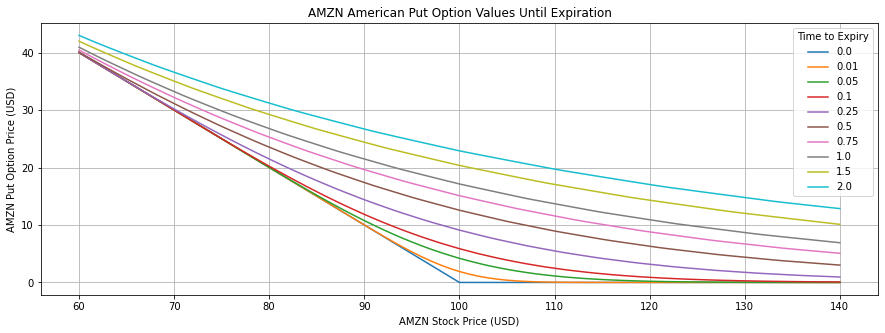

In [23]:
# American Put on AMZN:
range_T = [0,0.01,0.05,0.1,0.25,0.5,0.75,1,1.5,2]  #[i/10 for i in range(6)]
range_S = range(60,141)
prices = pd.DataFrame(index=range_S, columns=range_T)
for T in range_T:
    #print('Time: ', T) # to keep track of progress
    for S in range_S:
        amzn = Option(S=S, K=100, T=T, v=ewma_vol[-1], r=0.04, d=0) #initialize object
        prices.loc[S,T] = amzn.binomial(Put=True, n_steps=200, American=True) #American Option

# plot
prices.plot(title = 'AMZN American Put Option Values Until Expiration', figsize=(15,5), grid=True)
plt.ylabel('AMZN Put Option Price (USD)')
plt.xlabel('AMZN Stock Price (USD)')
plt.legend(title='Time to Expiry')
plt.show()

### American Straddle price on AMZN with S=range(60,140), K=100, T=range(0,2), v=?, r=0.04,d=0)


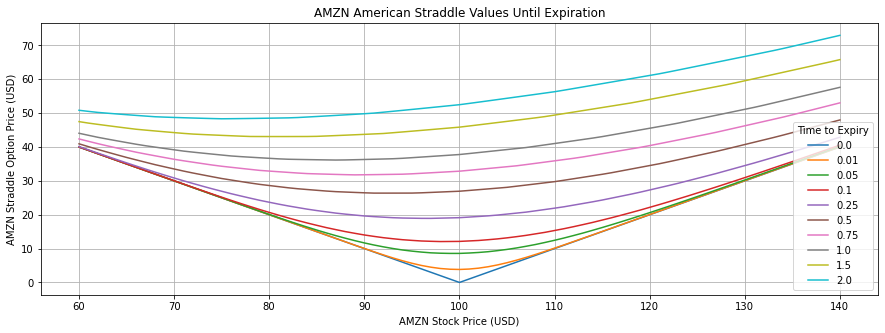

In [24]:
# American Straddle on AMZN:
range_T = [0,0.01,0.05,0.1,0.25,0.5,0.75,1,1.5,2]  #[i/10 for i in range(6)]
range_S = range(60,141)
prices = pd.DataFrame(index=range_S, columns=range_T)
for T in range_T:
    #print('Time: ', T) # to keep track of progress
    for S in range_S:
        amzn = Option(S=S, K=100, T=T, v=ewma_vol[-1], r=0.04, d=0) #initialize object
        prices.loc[S,T] = amzn.binomial(Call=True, n_steps=200,
                                        American=True) + amzn.binomial(Put=True, n_steps=200, American=True)

# plot
prices.plot(title = 'AMZN American Straddle Values Until Expiration', figsize=(15,5), grid=True)
plt.ylabel('AMZN Straddle Option Price (USD)')
plt.xlabel('AMZN Stock Price (USD)')
plt.legend(title='Time to Expiry')
plt.show()

### American Strangle price on AMZN with S=range(60,140), K=100, T=range(0,2), v=?, r=0.04,d=0)


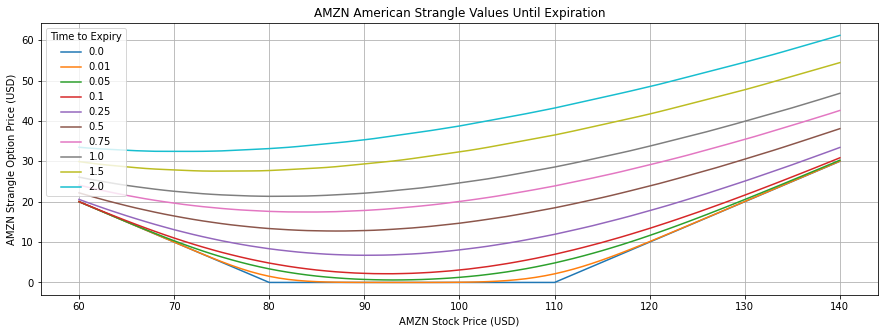

In [25]:
# American Strangle on AMZN:
range_T = [0,0.01,0.05,0.1,0.25,0.5,0.75,1,1.5,2]  #[i/10 for i in range(6)]
range_S = range(60,141)
prices = pd.DataFrame(index=range_S, columns=range_T)
for T in range_T:
    #print('Time: ', T) # to keep track of progress
    for S in range_S:
        amzn_long1 = Option(S=S, K=110, T=T, v=ewma_vol[-1], r=0.04, d=0) #initialize object
        amzn_long2 = Option(S=S, K=80 , T=T, v=ewma_vol[-1], r=0.04, d=0) #initialize object

        prices.loc[S,T] = amzn_long1.binomial(Call=True, n_steps=200, American=True)
        prices.loc[S,T]+= amzn_long2.binomial(Put=True,  n_steps=200, American=True)
# plot
prices.plot(title = 'AMZN American Strangle Values Until Expiration', figsize=(15,5), grid=True)
plt.ylabel('AMZN Strangle Option Price (USD)')
plt.xlabel('AMZN Stock Price (USD)')
plt.legend(title='Time to Expiry')
plt.show()

### American Collar price on AMZN with S=range(60,140), K=100, T=range(0,2), v=?, r=0.04,d=0)


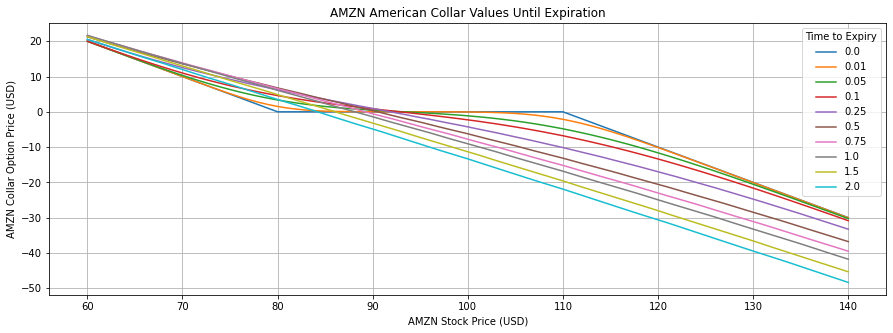

In [26]:
# American Collar on AMZN:
range_T = [0,0.01,0.05,0.1,0.25,0.5,0.75,1,1.5,2]  #[i/10 for i in range(6)]
range_S = range(60,141)
prices = pd.DataFrame(index=range_S, columns=range_T)
for T in range_T:
    #print('Time: ', T) # to keep track of progress
    for S in range_S:
        amzn_short = Option(S=S, K=110, T=T, v=ewma_vol[-1], r=0.04, d=0) #initialize object
        amzn_long  = Option(S=S, K=80 , T=T, v=ewma_vol[-1], r=0.04, d=0) #initialize object

        prices.loc[S,T] = amzn_long.binomial(Put=True,   n_steps=200, American=True)
        prices.loc[S,T]-= amzn_short.binomial(Call=True, n_steps=200, American=True)
# plot
prices.plot(title = 'AMZN American Collar Values Until Expiration', figsize=(15,5), grid=True)
plt.ylabel('AMZN Collar Option Price (USD)')
plt.xlabel('AMZN Stock Price (USD)')
plt.legend(title='Time to Expiry')
plt.show()

# Get Option Prices from yahooquery
# Compute implied vols
# Plot Vol Skew

In [27]:
#from yahooquery import Ticker
#import datetime as dt
tickers = ['SPY']
t = Ticker(tickers, asynchronous=True)

df = t.option_chain


# find the option that expires closest to ~1y from now
df = df[df.index.get_level_values(1).date >= dt.date.today()+dt.timedelta(200)]
df = df[df.index.get_level_values(1).date <= dt.date.today()+dt.timedelta(500)]

if len(df.index.get_level_values(1).unique())>1:
    dates_to_test = list(df.index.get_level_values(1).unique())
    closest_date_to_1y = []
    for i in dates_to_test:
        closest_date_to_1y.append(abs((i.date() - dt.date.today()).days - 365))
        
    idx_min = pd.Series(closest_date_to_1y).idxmin()
    closest_date_to_1y = dates_to_test[idx_min]
    
df = df[df.index.get_level_values(1) == closest_date_to_1y]
df['midPrice'] = (df['bid']+df['ask'])/2

#get latest prices
df['date'] = [i.date() for i in list(df.lastTradeDate)]
df = df[df['date'] == df['date'].max()]
df

contractSymbol  strike currency  lastPrice  \
symbol expiration optionType                                                   
SPY    2023-12-15 calls       SPY231215C00150000   150.0      USD     235.42   
                  calls       SPY231215C00200000   200.0      USD     191.00   
                  calls       SPY231215C00210000   210.0      USD     183.11   
                  calls       SPY231215C00225000   225.0      USD     168.00   
                  calls       SPY231215C00250000   250.0      USD     142.35   
...                                          ...     ...      ...        ...   
                  puts        SPY231215P00450000   450.0      USD      70.00   
                  puts        SPY231215P00455000   455.0      USD      72.18   
                  puts        SPY231215P00460000   460.0      USD      76.46   
                  puts        SPY231215P00470000   470.0      USD      88.21   
                  puts        SPY231215P00475000   475.0      USD      93.68   

                                 change  percentChange  openInterest     bid  \
symbol expiration optionType                                                   
SPY    2023-12-15 calls      -11.589996      -4.692116          59.0  234.54   
                  calls       -3.500000      -1.799486         210.0  188.05   
                  calls       -9.270004      -4.818590          33.0  178.89   
                  calls      -17.199997      -9.287255         127.0  165.25   
                  calls      -14.809998      -9.423516         136.0  142.91   
...                                 ...            ...           ...     ...   
                  puts         5.300003       8.191659       11189.0   67.46   
                  puts         2.930000       4.231047        6493.0   71.53   
                  puts         4.279999       5.929619       15359.0   75.85   
                  puts        21.710000      32.646614        1332.0   85.44   
                  puts         6.590004       7.566889         389.0   90.44   

                                 ask contractSize       lastTradeDate  \
symbol expiration optionType                                            
SPY    2023-12-15 calls       238.15      REGULAR 2022-12-16 17:55:13   
                  calls       191.64      REGULAR 2022-12-16 20:47:37   
                  calls       182.45      REGULAR 2022-12-16 14:37:53   
                  calls       168.76      REGULAR 2022-12-16 15:08:19   
                  calls       146.29      REGULAR 2022-12-16 17:06:01   
...                              ...          ...                 ...   
                  puts         70.24      REGULAR 2022-12-16 16:59:10   
                  puts         74.45      REGULAR 2022-12-16 20:27:46   
                  puts         78.95      REGULAR 2022-12-16 20:27:46   
                  puts         88.95      REGULAR 2022-12-16 17:04:49   
                  puts         93.95      REGULAR 2022-12-16 17:15:20   

                              impliedVolatility  inTheMoney  volume  midPrice  \
symbol expiration optionType                                                    
SPY    2023-12-15 calls                0.584599        True     7.0   236.345   
                  calls                0.510717        True     3.0   189.845   
                  calls                0.528020        True     1.0   180.670   
                  calls                0.500524        True     1.0   167.005   
                  calls                0.457540        True     1.0   144.600   
...                                         ...         ...     ...       ...   
                  puts                 0.139627        True    13.0    68.850   
                  puts                 0.136025        True    15.0    72.990   
                  puts                 0.134896        True    45.0    77.400   
                  puts                 0.146310        True     1.0    87.195   
                  puts        

In [28]:
# T in years
T = (closest_date_to_1y.date() - dt.date.today()).days / 365
T

0.9917808219178083

In [29]:
# Spot price
ticker_yahoo = yf.Ticker(tickers[0])
S = ticker_yahoo.history(period='10y').Close[-1]
S

383.2699890136719

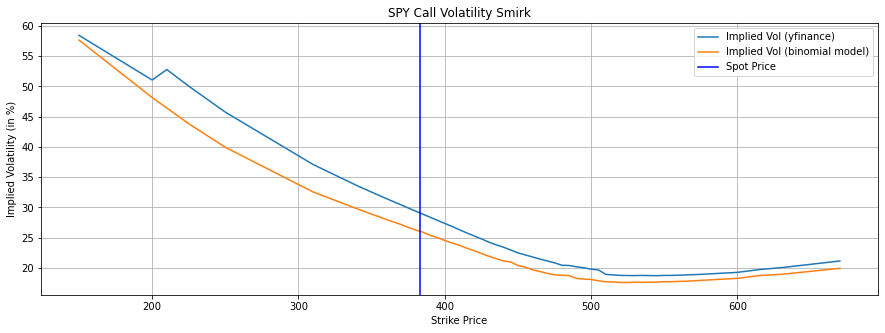

In [30]:
# do calls first
df_calls = df[df.index.get_level_values(2) == 'calls'].reset_index()[['strike','midPrice','impliedVolatility']]
df_calls = df_calls[df_calls['strike']>0]
df_calls = df_calls[df_calls['strike']<2*S]

data = df_calls.copy()
for idx in data.index:
    K = data.loc[idx,'strike']
    p = data.loc[idx,'midPrice']

    # bisection method for getting implied vol
    v1 = .1 #10% vol
    v2 = 9  #900% vol
    for i in range(50):
        spy = Option(S=S, K=K, T=T, v=(v1+v2)/2, r=0.04, d=0.016) #initialize object
        p1 = spy.binomial(Call=True, n_steps=200, American=True)
        if p1<p:
            v1 = (v1+v2)/2
        else:
            v2 = (v1+v2)/2
    df_calls.loc[idx,'implied_binomial'] = ((v1+v2)/2)
    
# only get implied output that is >= 10% avg implied vols given from yfinance (calc not stable for deep ITM options)
df_calls = df_calls[df_calls['implied_binomial']>df_calls['impliedVolatility'].min()/1.5]

# plot
fig = plt.subplots(1,1,figsize=(15,5))
plt.plot(df_calls['strike'],100*df_calls['impliedVolatility'], label='Implied Vol (yfinance)')
plt.plot(df_calls['strike'],100*df_calls['implied_binomial'], label='Implied Vol (binomial model)')
plt.axvline(x = S, color = 'b', label = 'Spot Price')
plt.title('SPY Call Volatility Smirk')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (in %)')
plt.grid()
plt.legend()
plt.show()

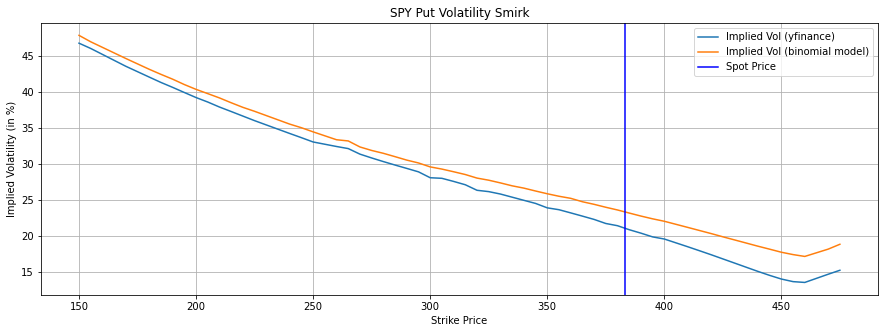

In [31]:
# do calls first
df_puts = df[df.index.get_level_values(2) == 'puts'].reset_index()[['strike','midPrice','impliedVolatility']]
df_puts = df_puts[df_puts['strike']>0]
df_puts = df_puts[df_puts['strike']<2*S]

data = df_puts.copy()
for idx in data.index:
    K = data.loc[idx,'strike']
    p = data.loc[idx,'midPrice']

    # bisection method for getting implied vol
    v1 = 0 #0% vol
    v2 = 9 #900% vol
    for i in range(50):
        spy = Option(S=S, K=K, T=T, v=(v1+v2)/2, r=0.04, d=0.0160) #initialize object
        p1 = spy.binomial(Put=True, n_steps=200, American=True)
        if p1<p:
            v1 = (v1+v2)/2
        else:
            v2 = (v1+v2)/2
    df_puts.loc[idx,'implied_binomial'] = ((v1+v2)/2)
    
# only get implied output that is >= 10% avg implied vols given from yfinance (calc not stable for deep ITM options)
df_puts = df_puts[df_puts['implied_binomial']>df_calls['impliedVolatility'].min()/1.5]

# plot
fig = plt.subplots(1,1,figsize=(15,5))
plt.plot(df_puts['strike'],100*df_puts['impliedVolatility'], label='Implied Vol (yfinance)')
plt.plot(df_puts['strike'],100*df_puts['implied_binomial'], label='Implied Vol (binomial model)')
plt.axvline(x = S, color = 'b', label = 'Spot Price')
plt.title('SPY Put Volatility Smirk')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (in %)')
plt.grid()
plt.legend()
plt.show()